# CheXScan Ensemble Experiments

## Libraries

In [1]:
import tensorflow as tf
from keras import datasets, layers, models
from keras.optimizers import Adam
from keras.optimizers import Adam as LegacyAdam
from keras.layers import Input, Average
from keras.applications import DenseNet121, InceptionV3, ResNet50, VGG16
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

## GPU Utilization

checks for available physical devices using TensorFlow's configuration

In [2]:
physical_devices = tf.config.list_physical_devices()

print("Available physical devices:")
for device in physical_devices:
    print(device)

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available")
    for gpu in gpu_devices:
        print("GPU device name:", gpu.name)
else:
    print("GPU is NOT available, using CPU")

Available physical devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU is available
GPU device name: /physical_device:GPU:0


In [3]:
# Get the list of available physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

# Check if there are GPUs available
if gpus:
    # Set memory growth for each GPU
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPU:", gpu)
else:
    print("No GPUs found.")

Memory growth set for GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Constants

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
CLASSES = ['normal', 'pneumonia', 'tuberculosis']
NUM_CLASSES = len(CLASSES)
EPOCHS = 20

## Access image directory

In [5]:
# Access image directory
root_dir = r"E:/chexscan/data"
train_dir = root_dir + "/train_data"
valid_dir = root_dir + "/test_data"

## Data Generator

In [6]:
img_size = IMAGE_SIZE

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip = True,
    zoom_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    fill_mode="constant",
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 4800 images belonging to 3 classes.


In [7]:
valid_datagen = ImageDataGenerator(rescale=1/255.)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 1200 images belonging to 3 classes.


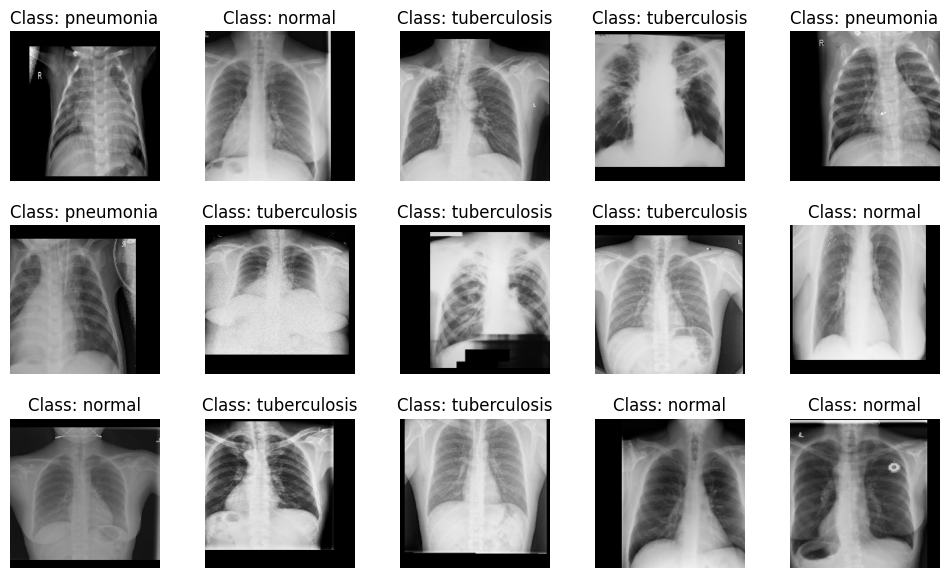

In [8]:
# Get the class indices and names from the train generator
class_indices = train_generator.class_indices
label_to_name = {idx: name for name, idx in class_indices.items()}
samples = train_generator.__next__()  # next fetches the image from the object. Each run gives a new set of images in the training set

images = samples[0]
target = samples[1]

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])

    # Convert the float target to integer (0 or 1)
    label_idx = tuple(target[i]).index(1)
    class_name = label_to_name[label_idx]

    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

## Training Parameters

In [9]:
loss_function = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.0001)
num_epochs = EPOCHS

## Evaluation Functions

In [10]:
def evaluate_model(model, valid_generator):
    predictions = model.predict_generator(valid_generator)
    true_labels = valid_generator.classes
    return true_labels, np.argmax(predictions, axis=1)

In [11]:
def plot_history_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

## TRAINING

defines the model architecture with convolutional and max-pooling layers, followed by fully connected layers and dropout regularization. 

compiled with a customized Adam optimizer and specified loss function. Training includes early stopping based on validation accuracy

after training, the model's performance is evaluated on a validation dataset, and metrics such as accuracy and classification report are computed.

visualizations, including training history and confusion matrix, are generated to assess the model's performance.

setting up an early stopping callback during model training to prevent overfitting and to stop training when the model performance stops improving

## Inception V3

In [14]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

inception_top = tf.keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

inception_model = tf.keras.Model(inputs=inception_model.input, outputs=inception_top(inception_model.output))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

inception_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

history_inception = inception_model.fit(train_generator, 
                                        validation_data=valid_generator, 
                                        epochs=num_epochs, 
                                        callbacks=[early_stopping])

true_labels_inception, predicted_labels_inception = evaluate_model(inception_model, valid_generator)
accuracy_inception = accuracy_score(true_labels_inception, predicted_labels_inception)
print("InceptionV3 Accuracy:", accuracy_inception)

plot_history_metrics(history_inception)

plot_confusion_matrix(true_labels_inception, predicted_labels_inception, CLASSES)

print("Classification Report for InceptionV3:")
print(classification_report(true_labels_inception, predicted_labels_inception, target_names=CLASSES))


Epoch 1/20


KeyboardInterrupt: 

## Performance Metrics

In [ ]:
import matplotlib.pyplot as plt

accuracy_alexnet_percent = accuracy_alexnet * 100
accuracy_densenet_percent = accuracy_densenet * 100
accuracy_inception_percent = accuracy_inception * 100
accuracy_resnet_percent = accuracy_resnet * 100
accuracy_vgg_percent = accuracy_vgg * 100

print(f"AlexNet Accuracy: {accuracy_alexnet_percent:.2f}%")
print(f"DenseNet121 Accuracy: {accuracy_densenet_percent:.2f}%")
print(f"InceptionV3 Accuracy: {accuracy_inception_percent:.2f}%")
print(f"ResNet50 Accuracy: {accuracy_resnet_percent:.2f}%")
print(f"VGG16 Accuracy: {accuracy_vgg_percent:.2f}%")

models = ['AlexNet', 'DenseNet121', 'InceptionV3', 'ResNet50', 'VGG16']
accuracies = [accuracy_alexnet_percent, accuracy_densenet_percent, accuracy_inception_percent, accuracy_resnet_percent, accuracy_vgg_percent]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Models')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Ensemble

In [ ]:
# Define the trained models in a list
# top_models = [alexnet_model, densenet_model, inception_model, resnet_model, vgg_model]
top_models = [alexnet_model, resnet_model, inception_model]

In [ ]:
for i, model in enumerate(top_models, start=1):
    model_path = f"final_model/selected_model_{i}.h5"
    model.save(model_path)

In [ ]:
def ensemble_predict(image, t3models):
    predictions = [model.predict(np.expand_dims(image, axis=0)) for model in t3models]
    return np.mean(predictions, axis=0)

## Saving the Ensemble Model

In [ ]:
# Load and preprocess the image
image_path = "E:/chexscan/exp/test/normal.png"
image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
image = cv2.resize(image, (224, 224))  # Resize to the required input size

# Convert image to NumPy array if it's not already and cast it to float32
image = np.array(image, dtype=np.float32)

# Normalize the pixel values
image /= 255.0

# Get ensemble predictions for the image
ensemble_predictions = ensemble_predict(image, top3_models)

# Display the ensemble predictions for the image
for class_index, class_name in enumerate(CLASSES):
    print(f"Ensemble Prediction for class '{class_name}': {ensemble_predictions[0][class_index]:.2f}")

print("ensemble predictions: ", ensemble_predictions)

# Convert predictions to class labels
predicted_class_indices = np.argmax(ensemble_predictions, axis=1)
predicted_class_names = [CLASSES[i] for i in predicted_class_indices]


<!-- # Make predictions using the ensemble model
predictions = ensemble_model.predict(input_image)

# Extract class names and corresponding probabilities
class_names = ["normal", "pneumonia", "tuberculosis"]  # Replace with your actual class names
probabilities = predictions[0]

# Sort the probabilities in descending order
sorted_indices = np.argsort(probabilities)[::-1]

# Display the top predicted class and its confidence
top_class = class_names[sorted_indices[0]]
top_confidence = probabilities[sorted_indices[0]]
print(f"Top predicted class: {top_class}, Confidence: {top_confidence:.2f}")

# Display the next two predicted classes and their confidences
for i in range(1, 3):
    class_name = class_names[sorted_indices[i]]
    confidence = probabilities[sorted_indices[i]]
    print(f"Predicted class {i+1}: {class_name}, Confidence: {confidence:.2f}") -->


In [ ]:
# Define the input shape based on your models
input_shape = (224, 224, 3)  # Ex|ample input shape for RGB images of size 299x299

# Define inputs for the ensemble model
ensemble_inputs = [Input(shape=input_shape) for _ in range(len(top3_models))]

# Get outputs of the top 3 models
model_outputs = [model(inputs) for model, inputs in zip(top3_models, ensemble_inputs)]

# Average the outputs
ensemble_output = Average()(model_outputs)

# Create the ensemble model
ensemble_model = Model(inputs=ensemble_inputs, outputs=ensemble_output)

# Compile the ensemble model (if needed)
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.save('ensemble_model_04.h5')

In [ ]:
ensemble_model.save('ensemble_model_05.keras')

In [ ]:
alexnet_model.save('alexnet_model.keras')
densenet_model.save('densenet_model.keras')
inception_model.save('inception_model.keras')
resnet_model.save('resnet_model.keras')
vgg_model.save('vgg_model.keras')